---
title: "CODES: ADAR Regulates APOL1 via A-to-I RNA Editing by Inhibition of MDA5 Activation in a Paradoxical Biological Circuit"
author: "Authors ....."
date: "05/09/2022"
link-citations: yes
output: 
  rmdformats::downcute:
  self_contained: true
  toc: true
  toc_float: true
  toc_depth: 5
  lightbox: true
  gallery: true
  use_bookdown: true
---

# Preprocessing ALU Editing Index:

Machine:

- System: CentOS Linux release 7.9.2009
- Processor: Intel(R) Xeon(R) CPU E5-2640 v4 @ 2.40GHz
- RAM: 64GB

We runnned in bash all Humans and Mice samples on [RNAEditingIndexer](https://github.com/a2iEditing/RNAEditingIndexer) tool. We installed and runned RNAEditingIndexer as a container service build from a docker file povided by RNAEditingIndexer. The dependencies was installed via anaconda.

- samtools=1.9
- bedtools=2.27.1
- bamutil=1.0.14
- java-jdk=8.0.92
- python=2.7.16

After preprocessing ALU Editing Index, we have one file for each specie:

- **df_a2i_H**: Humans ALU Editing Index, saved as 'RNAIndexer_human.csv'
- **df_a2i_H**: Mouse ALU Editing Index, saved as 'RNAIndexer_mouse.csv'

## Human
We used reference genome hg38 and the full RNAEditingIndexer database.

In [ ]:
%%bash
docker run \
  -u $(id -u ${USER}):$(id -g ${USER})\
  -v /path_to_bams:/data/input_bams:ro -v /path_to_editing_results:/data/output_editing:rw\
  a2i_editing_index:1.0 RNAEditingIndex -d /data/input_bams\
  -l /data/output_editing/logs_dir -o /data/output_editing/cmpileups\
  -os /data/output_editing/summary_dir\
  --genome hg38

## Mouse
We have runned a similar code for Human above, but before we liftedover the RNAEdtingIndexer Human database to the Mouse-clone coordinates. We selected only the APOL1 region and transformed the coordinates to the Mouse positions.  

In [ ]:
%%bash
docker run \
  -u $(id -u ${USER}):$(id -g ${USER})\
  -v /path_to_bams:/data/input_bams:ro -v /path_to_editing_results:/data/output_editing:rw\
  a2i_editing_index:1.0 RNAEditingIndex -d /data/input/trimmed_bams\
  -l /data/output_editing/logs_dir -o /data/output_editing/cmpileups\
  -os /data/output_editing/summary_dir\
  --genome UserProvided \
  -gf /data/input/annotation/GRCm39.primary_assembly.genome.TG_Mouse-BAC.fa\
  --regions /data/Resources/ucscHg38Alu_chr22.bed.gz\
  --snps /data/Resources/ucscHg38CommonGenomicSNPs150_chr22.bed.gz\
  --refseq /data/Resources/ucscHg38RefSeqCurated_chr22.bed.gz

# Preprocessing A-to-I Editing:

We runnned in bash all Humans and Mice samples on [REDItools 2.0](https://github.com/BioinfoUNIBA/REDItools2). We installed and runned REDItools 2.0 on a anaconda enviroment.

- samtools=1.2
- tabix=1.11
- htslib=1.12
- mpi4py=3.0.3
- sortedcontainers=2.4.0
- psutil=4.4.2
- netifaces=0.10.9
- pysam=0.17.0
- python=2.7.15

Both human and Mouse we applied the same code for each reference genome and differents paths.

After the preprocessing step, we have two principal files as result:
- **df_H**: Human editing levels DataFrame, saved as 'REDItools_Human.csv'
- **df_M**: Mouse editing levels DataFrame, saved as 'REDItools_Mouse.csv'

## Human

In [ ]:
%%bash
#!/bin/bash

pathIn='./path_to_human_bams/' # bams to analyse
ref='/path_to_human_reference_genome/hg38.fa' # reference genome 
pathOut='./path_to_human_reditools_output/' # output

arr=(${pathIn}*.bam) # get all bam files as a list

# run REDItools for each bam
for filename in ${arr[@]##*/}; do
    echo ${filename}
    python ./reditools2.0/src/cineca/reditools.py -f ${pathIn}${filename} -r ${ref} -o ${pathOut}${filename}.RES.tsv
done

## Mouse

In [ ]:
%%bash
#!/bin/bash

pathIn='./path_to_mouse_bams/' # bams to analyse
ref='/path_to_mouse_reference_genome/hg38.fa' # reference genome 
pathOut='./path_to_mouse_reditools_output/' # output

arr=(${pathIn}*.bam) # get all bam files as a list

# run REDItools for each bam
for filename in ${arr[@]##*/}; do
    echo ${filename}
    python ./reditools2.0/src/cineca/reditools.py -f ${pathIn}${filename} -r ${ref} -o ${pathOut}${filename}.RES.tsv
done

# Concatenating REDItools outputs for each specie
We concatenated all results from REDItools with the same code. To do that we used pandas and numpy, both are **python=3.9.12** packages to data analysis.

- python=3.9.12
- numpy=1.21.6
- pandas=1.2.2

In [ ]:
import os
import pandas as pd
import numpy as np

## Human

### Concatenating Results (H)
While concatenating, we calculate the editing level based on [getOverallEditing.py](https://github.com/BioinfoUNIBA/QEdit/blob/master/scripts/getOverallEditing.py) and [GetREI.py](https://github.com/BioinfoUNIBA/QEdit/blob/master/scripts/GetREI.py) scripts available at [REDItools github](https://github.com/BioinfoUNIBA).
- If the reference columns is 'A', editing level = (number of G's) / (number of G's + number of A's)
- If the reference columns is 'T', editing level = (number of C's) / (number of C's + number of T's)

In [ ]:
# pathIN = '/path_to_human_reditools_outputs/' # path with reditools results
pathIN = '/media/guilherme/TOSHIBA EXT/backups_notebook_11032022/rnaEditing/neptune_human_files/RnaEditingProject/bams/REDItools_outputs/'
files = [f for f in os.listdir(pathIN) if f.endswith('G.apol1_UTRplusALUs.bam.RES.tsv.gz')]

aux_df = []
for f in files:
    df_H = pd.read_csv(pathIN+f, sep='\t')
    df_H['Sample'] = f.split('.')[0].replace('G','')    
    aux_df.append(df_H)

df_H = pd.concat(aux_df)
del(aux_df)

df_H = df_H[(df_H['Reference'].isin(['A','T']))]
df_H['Sample'] = df_H['Sample'].apply(int)
df_H[['count_A','count_C','count_G','count_T']] = df_H['BaseCount[A,C,G,T]'].str.replace('[','').str.replace(']','').str.split(',',expand=True).apply(pd.to_numeric)
df_H['editing_level'] = np.where((df_H['Reference']=='A'), df_H.count_G/(df_H.count_G+df_H.count_A), df_H.count_C/(df_H.count_C+df_H.count_T))
df_H['editing_level_100'] = df_H['editing_level']*100

df_H.reset_index(inplace=True, drop=True)

/tmp/ipykernel_682752/355093992.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_H[['count_A','count_C','count_G','count_T']] = df_H['BaseCount[A,C,G,T]'].str.replace('[','').str.replace(']','').str.split(',',expand=True).apply(pd.to_numeric)


### Comparing edited positions with [REDIportal Database](http://srv00.recas.ba.infn.it/atlas/index.html) (H)
We download the hg38 reference genome and filter positions in APOL1 coordinates.

In [ ]:
fileTABLE = '/media/guilherme/TOSHIBA EXT/backups_notebook_11032022/rnaEditing/dataBase/TABLE1_hg38_chr22.txt'

df_redi = pd.read_csv(fileTABLE, sep='\t')

cols = ['Position','db','type','dbsnp','repeat','ExonicFunc.refGene']
df_redi = df_redi[cols]

df_H.loc[:,['db','type','dbsnp','repeat','ExonicFunc.refGene']] = np.nan

for l in df_H.Position.unique():
    if l in df_redi['Position'].values:
        df_H.loc[df_H['Position']==l, ['db','type','dbsnp',
                                   'repeat','ExonicFunc.refGene']] = df_redi[df_redi['Position']==l][cols[1:]].values[0]
    
df_H.dropna(subset=['db','type','dbsnp','repeat','ExonicFunc.refGene'], inplace=True)

### Filtering AluSC and AluY (H)

In [ ]:
# AluSC
start_pos1 = 36266096
end_pos1 = 36266380

# AluY
start_pos2 = 36266624
end_pos2 = 36266924

df_H = df_H[ ((df_H.Position>=start_pos1) & (df_H.Position<=end_pos1)) | ((df_H.Position>=start_pos2) & (df_H.Position<=end_pos2)) ]

### Filtering by minimum reads support (10) and editing level greather or equal 1% (H)

In [ ]:
df_H = df_H[(df_H['Coverage-q30']>10) & (df_H.editing_level_100>=1)]

## Mouse

### Concatenating Results (M)
In addition to concatenating and calculaing editing level, we transformed APOL1 Mouse-clone coordinates to hg38 coordinates.

In [ ]:
pathIN = '/media/guilherme/TOSHIBA EXT/backups_notebook_11032022/rnaEditing/mice_files_calum/REDItools_output/'

In [ ]:
files = [ f for f in os.listdir(pathIN) if f.endswith('.tsv') ]

apol1_coord = 36228239 # Colum transformation
apol1_start = 37794 #APOL1 start in clone
apol1_end = 39295 #APOL1 end in clone

aux_df = []
for f in files:
    df_M = pd.read_csv(pathIN+f, sep='\t')
    df_M = df_M[(df_M.Position>=apol1_start) & (df_M.Position<=apol1_end)]
    df_M['Position'] = df_M['Position'] + apol1_coord
    if '_' in f:
        df_M['Sample'] = f.split('_')[0]
    else:
        df_M['Sample'] = f.split('.')[0] 
    aux_df.append(df_M)

df_M = pd.concat(aux_df)
del(aux_df)

df_M = df_M[(df_M['Reference'].isin(['A','T']))] # & (df['Coverage-q30']>=10)]
df_M['Sample'] = df_M['Sample'].apply(int)
df_M[['count_A','count_C','count_G','count_T']] = df_M['BaseCount[A,C,G,T]'].str.replace('[','').str.replace(']','').str.split(',',expand=True).apply(pd.to_numeric)
df_M['editing_level'] = np.where((df_M['Reference']=='A'), df_M.count_G/(df_M.count_G+df_M.count_A), df_M.count_C/(df_M.count_C+df_M.count_T))
df_M['editing_level_100'] = df_M['editing_level']*100

df_M.reset_index(inplace=True, drop=True)

/tmp/ipykernel_682752/1585491870.py:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df_M[['count_A','count_C','count_G','count_T']] = df_M['BaseCount[A,C,G,T]'].str.replace('[','').str.replace(']','').str.split(',',expand=True).apply(pd.to_numeric)


### Comparing edited positions with [REDIportal Database](http://srv00.recas.ba.infn.it/atlas/index.html) (M)
We download the hg38 reference genome and filtered positions in APOL1 coordinates.

In [ ]:
fileTABLE = '/media/guilherme/TOSHIBA EXT/backups_notebook_11032022/rnaEditing/dataBase/TABLE1_hg38_chr22.txt'

df_redi = pd.read_csv(fileTABLE, sep='\t')

cols = ['Position','db','type','dbsnp','repeat','ExonicFunc.refGene']
df_redi = df_redi[cols]

df_M.loc[:,['db','type','dbsnp','repeat','ExonicFunc.refGene']] = np.nan

for l in df_M.Position.unique():
    if l in df_redi['Position'].values:
        df_M.loc[df_M['Position']==l, ['db','type','dbsnp',
                                   'repeat','ExonicFunc.refGene']] = df_redi[df_redi['Position']==l][cols[1:]].values[0]

### Filtering AluSC and AluY (M)

In [ ]:
start_pos1 = 36266096
end_pos1 = 36266380

start_pos2 = 36266624
end_pos2 = 36266924

df_M = df_M[ ((df_M.Position>=start_pos1) & (df_M.Position<=end_pos1)) | ((df_M.Position>=start_pos2) & (df_M.Position<=end_pos2)) ]

### Filtering by minimum reads support (10) and editing level greather or equal 1% (M)

In [ ]:
df_M = df_M[(df_M['Coverage-q30']>10) & (df_M.editing_level_100>=1)]

# Saving DataFrames to use in statistical analysis

In [ ]:
df_H.to_csv('REDItools_Human.csv', index=False)
df_M.to_csv('REDItools_Mouse.csv', index=False)

# Data Analysis 

**Requirement List**

- python=3.9.12
- numpy=1.21.6
- pandas=1.2.2
- scipy=1.8.0
- matplotlib=3.5.1 
- seaborn=0.11.1 
- venn=0.1.3
- statannotations=0.4.4
- pingouin=0.5.1
- statsmodels=0.13.2
- imbalanced-learn=0.7.0
- scikit-learn=0.24.1

In [ ]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from statannotations.Annotator import Annotator 

In [ ]:
labels_ticks_fontsize = 12
labels_fontsize = 16
title_fontsize = 20

human_color = (216/255, 27/255, 96/255)
mouse_baseline_color = (30/255, 136/255, 229/255)
mouse_ifn_color = (255/255, 193/255, 7/255)

## RNAEditingIndexer Analysis

### Human

In [ ]:
df_a2i_H = pd.read_csv('RNAIndexer_human.csv')

### Mouse

In [ ]:
df_a2i_M = pd.read_csv('RNAIndexer_mouse.csv')

### FIGURES 6B and 6C

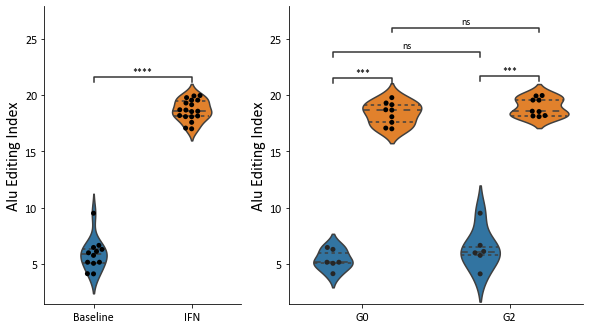

In [ ]:
fig, (ax, axGen) = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=False, figsize=(16.6/2,23.4/5),
                                    gridspec_kw={"width_ratios": (0.4, .6)})

x='Condition'
y='A-To-G'
v='Condition'

data=df_a2i_M
order = ['baseline','ifn']

sns.violinplot(x=x, y=y, data=data, ax=ax, order=order, width=0.4,scale="count", inner='quartile',legend=True)
sns.swarmplot(x=x, y=y,data=data, order=['baseline','ifn'], color='black', ax=ax)

order=data[v].unique().tolist()
box_pairs=list(itertools.combinations(order, 2))

annotator = Annotator(ax, box_pairs, data=data, x=x, y=y, order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=False)
annotator.apply_and_annotate()


ax.set_xlabel(None)
ax.set_ylabel("Alu Editing Index", fontsize=labels_fontsize)
ax.set_xticklabels(['Baseline', 'IFN'])
ax.tick_params(axis='both', labelsize=labels_ticks_fontsize)
ax.tick_params(axis='x', labelsize=labels_ticks_fontsize)
# ax.set_ylim([None,25])
ax.grid(axis='y')
ax.set_axisbelow(True)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.grid(False)
######################
######################
axGen = fig.add_subplot(1,2,2, sharey=ax)

x='Genotype'
y='A-To-G'
v=x

data=df_a2i_M

order=['G0', 'G2']
hue_order=['baseline','ifn']
box_pairs=[
    [('G0', 'baseline'),('G0', 'ifn')],
    [('G2', 'baseline'),('G2', 'ifn')],
    [('G0', 'baseline'),('G2', 'baseline')],
    [('G0', 'ifn'),('G2', 'ifn')]

]

sns.swarmplot(x=x, y=y,data=data, order=order, hue='Condition',hue_order=hue_order,  color='black', ax=axGen, dodge=True)
sns.violinplot(x=x, y=y, data=data, order=order, hue='Condition', hue_order=hue_order, ax=axGen, width=0.8, scale="count", inner='quartile')

annotator = Annotator(axGen, box_pairs, data=data, x=x, y=y, 
                      hue='Condition',order=order, hue_order=hue_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=False)
annotator.apply_and_annotate()

h, l = axGen.get_legend_handles_labels()
axGen.legend().remove()


axGen.set_xlabel(None)
axGen.set_ylabel("Alu Editing Index", fontsize=labels_fontsize)
axGen.tick_params(axis='both', labelsize=labels_ticks_fontsize)
axGen.tick_params(axis='x', labelsize=labels_ticks_fontsize)
# axGen.set_ylim([None,25])
axGen.grid(axis='y')
axGen.set_axisbelow(True)

axGen.spines['right'].set_visible(False)
axGen.spines['top'].set_visible(False)

axGen.grid(False)

fig.get_axes()[1].remove()
######################
######################

fig.tight_layout()

### Human vs Mouse

#### Under-sampling Human data
Since we have 373 human samples and only 30 mouse samples, we choose under-sampling human data to infer statistical differences between **Human vs Mouse Baseline** and **Human vs Mouse IFN**.
To do that we use an [unsupervised cluster based method](https://jmlr.org/papers/v18/16-365.html) to keep the essential characteristics of the dataset.

In [ ]:
from imblearn.under_sampling import ClusterCentroids

In [ ]:
df_a2i_H['Specie'] = 'Human'
df_a2i_M['Specie'] = 'Mouse'

H_M_indexer = pd.concat([df_a2i_H, df_a2i_M])

In [ ]:
H_M_resampled_list = []

Resampling considering **ALL** Mouse data

In [ ]:
X = H_M_indexer[['A-To-C', 'A-To-G', 'A-To-T', 'C-To-A', 'C-To-G', 'C-To-T']].values
y = H_M_indexer.Specie.values

cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X, y)

H_M_resampled_list.append( pd.DataFrame(X_resampled,columns=['A-To-C', 'A-To-G', 'A-To-T', 'C-To-A', 'C-To-G', 'C-To-T']) )
H_M_resampled_list[-1]['Specie'] = y_resampled
H_M_resampled_list[-1]['Condition'] = 'ALL'

Resampling considering **IFN** Mouse data

In [ ]:
H_M_indexer_R = H_M_indexer[H_M_indexer.Condition!='baseline'].copy()
X = H_M_indexer_R[['A-To-C', 'A-To-G', 'A-To-T', 'C-To-A', 'C-To-G', 'C-To-T']].values
y = H_M_indexer_R.Specie.values

cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X, y)

H_M_resampled_list.append( pd.DataFrame(X_resampled,columns=['A-To-C', 'A-To-G', 'A-To-T', 'C-To-A', 'C-To-G', 'C-To-T']) )
H_M_resampled_list[-1]['Specie'] = y_resampled
H_M_resampled_list[-1]['Condition'] = 'ifn'

Resampling considering **BASELINE** Mouse data

In [ ]:
H_M_indexer_R = H_M_indexer[H_M_indexer.Condition!='ifn'].copy()
X = H_M_indexer_R[['A-To-C', 'A-To-G', 'A-To-T', 'C-To-A', 'C-To-G', 'C-To-T']].values
y = H_M_indexer_R.Specie.values

cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X, y)

H_M_resampled_list.append( pd.DataFrame(X_resampled,columns=['A-To-C', 'A-To-G', 'A-To-T', 'C-To-A', 'C-To-G', 'C-To-T']) )
H_M_resampled_list[-1]['Specie'] = y_resampled
H_M_resampled_list[-1]['Condition'] = 'baseline'

In [ ]:
H_M_resampled = pd.concat(H_M_resampled_list)

#### Visual Analysis of Resampling

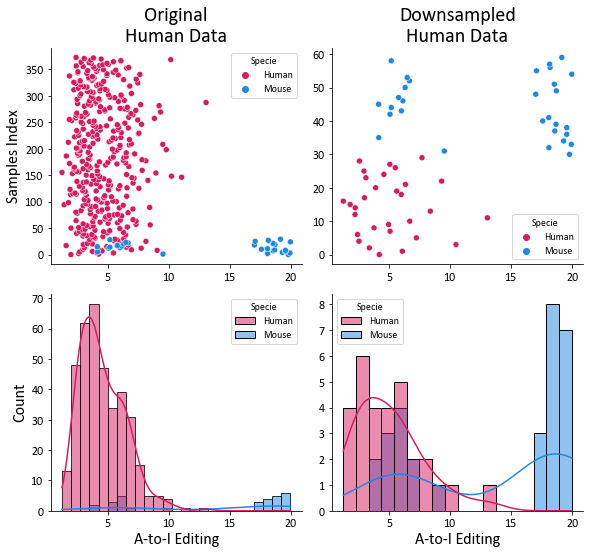

In [ ]:
fig = plt.figure(figsize=(16.6/2,23.4/3))

ax_o = fig.add_subplot(2,2,1) # scatter of original dataset
ax_r = fig.add_subplot(2,2,2) # scatter of resampled dataset

hs_o = fig.add_subplot(2,2,3, sharex=ax_o) # histogram of original dataset
hs_r = fig.add_subplot(2,2,4, sharex=ax_r) # histogram of resampled dataset

### ORIGINAL DATA ###
data = H_M_indexer
sns.scatterplot(x='A-To-G', y=data.index, hue='Specie', palette=[human_color, mouse_baseline_color],
                data=data, ax=ax_o)
ax_o.set_title('Original\nHuman Data', fontsize=title_fontsize)
ax_o.set_ylabel("Samples Index", fontsize=labels_fontsize)
ax_o.set_xlabel(None)
ax_o.tick_params(axis='x', labelsize=labels_ticks_fontsize)
ax_o.tick_params(axis='y', labelsize=labels_ticks_fontsize)
ax_o.spines['right'].set_visible(False)
ax_o.spines['top'].set_visible(False)

sns.histplot(x='A-To-G', hue='Specie', palette=[human_color, mouse_baseline_color], kde=True,data=data, ax=hs_o)
hs_o.set_xlabel("A-to-I Editing", fontsize=labels_fontsize)
hs_o.set_ylabel("Count", fontsize=labels_fontsize)
hs_o.tick_params(axis='x', labelsize=labels_ticks_fontsize)
hs_o.tick_params(axis='y', labelsize=labels_ticks_fontsize)
hs_o.spines['right'].set_visible(False)
hs_o.spines['top'].set_visible(False)

### RESAMPLED DATA ###
data = H_M_resampled[H_M_resampled.Condition=='ALL']

sns.scatterplot(x='A-To-G', y=data.index, hue='Specie', palette=[human_color, mouse_baseline_color],
                data=data,ax=ax_r)
ax_r.set_title('Downsampled\nHuman Data', fontsize=title_fontsize)
ax_r.set_ylabel(None)#"Samples Index", fontsize=labels_fontsize)
ax_r.set_xlabel(None)
ax_r.tick_params(axis='x', labelsize=labels_ticks_fontsize)
ax_r.tick_params(axis='y', labelsize=labels_ticks_fontsize)
ax_r.spines['right'].set_visible(False)
ax_r.spines['top'].set_visible(False)

sns.histplot(x='A-To-G', hue='Specie', palette=[human_color, mouse_baseline_color],
             data=data, bins=18, ax=hs_r, kde=True)
hs_r.set_xlabel("A-to-I Editing", fontsize=labels_fontsize)
hs_r.set_ylabel(None)
hs_r.tick_params(axis='x', labelsize=labels_ticks_fontsize)
hs_r.tick_params(axis='y', labelsize=labels_ticks_fontsize)
hs_r.spines['right'].set_visible(False)
hs_r.spines['top'].set_visible(False)

fig.tight_layout()

### FIGURE 5E

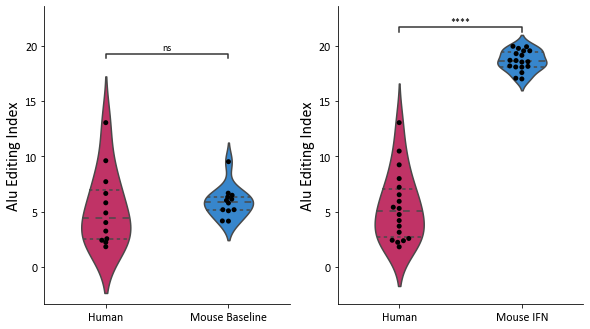

In [ ]:
fig = plt.figure(figsize=(16.6/2,23.4/5))
ax = fig.add_subplot(1,2,1)

x = 'Specie'
y = 'A-To-G'
hue = ''

order=['Human','Mouse']
box_pairs=[
    ('Human', 'Mouse')
]


data = H_M_resampled[H_M_resampled.Condition=='baseline']
sns.swarmplot(x=x, y=y,data=data, order=order, color='black', ax=ax, dodge=True)
sns.violinplot(x=x,y=y, data=data, order=order, palette=[human_color, mouse_baseline_color], width=0.4, scale="count", inner='quartile', ax=ax)#fliersize=False,

annotator = Annotator(ax, box_pairs, data=data, x=x, y=y,order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=False)
annotator.apply_and_annotate()

ax.set_ylabel("Alu Editing Index", fontsize=labels_fontsize)
ax.set_xlabel("")
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set_xticklabels(['Human', 'Mouse Baseline'])
ax.grid(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', labelsize=labels_ticks_fontsize)

#######################
#######################

ax2 = fig.add_subplot(1,2,2, sharey=ax)

x = 'Specie'
y = 'A-To-G'
hue = ''

order=['Human','Mouse']
box_pairs=[
    ('Human', 'Mouse')
]

data=H_M_resampled[H_M_resampled.Condition=='ifn']

sns.swarmplot(x=x, y=y,data=data, order=order, color='black', ax=ax2, dodge=True)
sns.violinplot(x=x,y=y, data=data, order=order, palette=[human_color, mouse_baseline_color],
               fliersize=False, width=0.4, scale="count", inner='quartile', ax=ax2)

annotator = Annotator(ax2, box_pairs, data=data, x=x, y=y,order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=False)
annotator.apply_and_annotate()

ax2.set_ylabel("Alu Editing Index", fontsize=labels_fontsize)
ax2.set_xlabel("")
ax2.grid(axis='y')
ax2.set_axisbelow(True)

ax2.set_xticklabels(['Human', 'Mouse IFN'])
ax2.tick_params(axis='both', labelsize=labels_ticks_fontsize)

ax2.grid(False)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

fig.tight_layout()

## REDItools Analysis

### Human

In [ ]:
df_H = pd.read_csv('REDItools_Human.csv')

### FIGURE 4A

#### Human AluSC

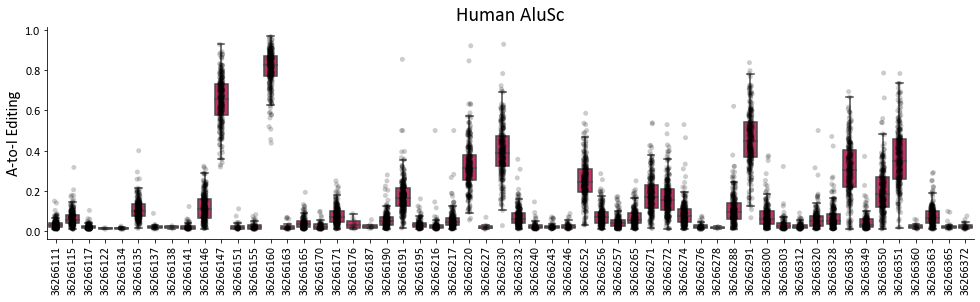

In [ ]:
fig = plt.figure(figsize=(16.6,23.4/6))
ax_box1 = fig.add_subplot(1,1,1)

start_pos = 36266096
end_pos = 36266380

data = df_H[(df_H['Position']>=start_pos) & (df_H['Position']<=end_pos)]

sns.stripplot(x='Position', y='editing_level', color='black',alpha=.2, data=data, ax=ax_box1)
sns.boxplot(x='Position', y='editing_level', data=data,
            color=human_color,
            fliersize=False,ax=ax_box1)

ax_box1.set_xlabel(None)
ax_box1.set_ylabel("A-to-I Editing", fontsize=labels_fontsize)
ax_box1.tick_params(axis='x', rotation=90, labelsize=labels_ticks_fontsize)
ax_box1.tick_params(axis='y', labelsize=labels_ticks_fontsize)
ax_box1.set_title('Human AluSc', fontsize=title_fontsize)
ax_box1.set_axisbelow(True)
ax_box1.spines['right'].set_visible(False)
ax_box1.spines['top'].set_visible(False)

#### Human AluY

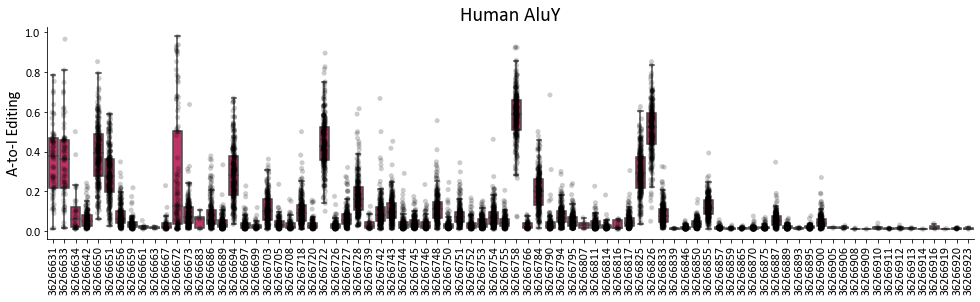

In [ ]:
fig = plt.figure(figsize=(16.6,23.4/6))
ax_box1 = fig.add_subplot(1,1,1)

start_pos = 36266624
end_pos = 36266924

data = df_H[(df_H['Position']>=start_pos) & (df_H['Position']<=end_pos)]

sns.stripplot(x='Position', y='editing_level', color='black',alpha=.2, data=data, ax=ax_box1)
sns.boxplot(x='Position', y='editing_level', data=data,
            color=human_color, fliersize=False,ax=ax_box1)

ax_box1.set_xlabel(None)
ax_box1.set_ylabel("A-to-I Editing", fontsize=labels_fontsize)
ax_box1.tick_params(axis='x', rotation=90, labelsize=labels_ticks_fontsize)
ax_box1.tick_params(axis='y', labelsize=labels_ticks_fontsize)
ax_box1.set_title('Human AluY', fontsize=title_fontsize)
ax_box1.set_axisbelow(True)

ax_box1.spines['right'].set_visible(False)
ax_box1.spines['top'].set_visible(False)

### Mouse

In [ ]:
df_M = pd.read_csv('REDItools_Mouse.csv')

#### Filter positions with at least 4 samples in each Condition (baseline/ifn)

To infer statisticals differences between Baseline and IFN in each coordinate,the possition should share at least 4 samples in both conditions.   

In [ ]:
min_sample = 4

table_baseline = df_M[df_M['Condition']=='baseline'][['Position', 'Pedigree', 'editing_level_100']].pivot_table(index='Position',
                                                                                                                columns='Pedigree',
                                                                                                                values='editing_level_100',
                                                                                                                aggfunc='median')

table_ifn = df_M[df_M['Condition']=='ifn'][['Position', 'Pedigree', 'editing_level_100']].pivot_table(index='Position',
                                                                                                      columns='Pedigree',
                                                                                                      values='editing_level_100',
                                                                                                      aggfunc='median')

table = table_baseline.dropna(thresh=min_sample).fillna(0).merge(table_ifn.dropna(thresh=min_sample).fillna(0), on='Position')

samples_ordered_condition = df_M[['Pedigree','Condition']].drop_duplicates().sort_values('Condition')['Pedigree'].tolist()

hm = table[samples_ordered_condition].fillna(0)

#### Calculate Mann-Withney with Benjamin-Hochberg correction

In [ ]:
import pingouin as pg
import statsmodels.api as sm
import statsmodels as sm

In [ ]:
stat_aux = []

for pos in df_M.loc[df_M.Position.isin(hm.index),:].Position.unique():
    df_pg = pg.pairwise_ttests(dv='editing_level_100', between='Condition',padjust='fdr_bh',
                               parametric=False, data=df_M[df_M['Position']==pos])
    df_pg['Position'] = pos
    stat_aux.append(df_pg)

df_stat = pd.concat(stat_aux)

p_values = df_stat['p-unc'].values
p_adj = sm.stats.multitest.multipletests(p_values.tolist(), method='fdr_bh')
df_stat['p-adj'] = p_adj[1]
df_stat['log_padj'] = -np.log(df_stat['p-adj'])

### FIGURE 6A
#### Mouse AluSC

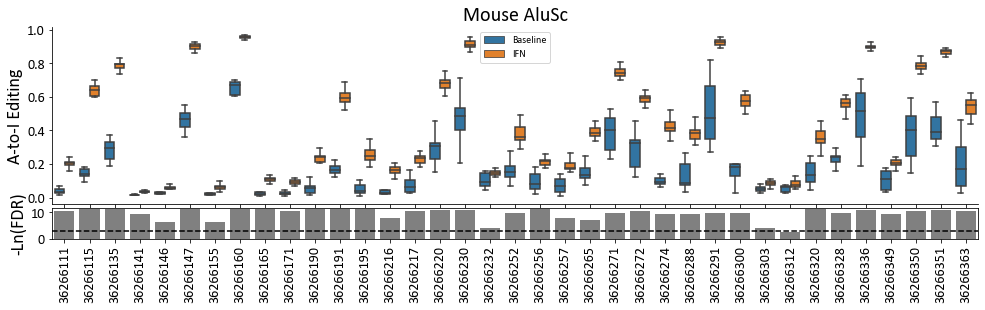

In [ ]:
f, (ax_box1, ax_bar) = plt.subplots(2, sharex=True, figsize=(16.6,23.4/6),
                                    gridspec_kw={"height_ratios": (.85, .15), 'hspace':.035})

start_pos1 = 36266096
end_pos1 = 36266380

df_overed_apol = df_M[df_M.Position.isin(hm.index)]
data1 = df_overed_apol[(df_overed_apol['Position']>=start_pos1) & (df_overed_apol['Position']<=end_pos1)]#.groupby('Position').mean().reset_index()

sns.boxplot(x='Position', y='editing_level', hue='Condition',
            hue_order=['baseline','ifn'], data=data1, fliersize=False,ax=ax_box1)

ax_box1.set_xlabel(None)
ax_box1.set_ylabel("A-to-I Editing", fontsize=labels_fontsize)
ax_box1.tick_params(axis='y', labelsize=labels_ticks_fontsize)
ax_box1.set_title('Mouse AluSc', fontsize=title_fontsize)
ax_box1.set_axisbelow(True)
ax_box1.spines['right'].set_visible(False)
ax_box1.spines['top'].set_visible(False)

h, l = ax_box1.get_legend_handles_labels()
l = ['Baseline', 'IFN']
ax_box1.legend(h, l)

data2 = df_stat[(df_stat['Position']>=start_pos1) & (df_stat['Position']<=end_pos1)]

sns.barplot(x='Position', y='log_padj',
            data=data2,color='gray',
            ax=ax_bar)

ax_bar.set_xlabel(None)
ax_bar.axhline(-np.log(0.05), color='black', ls='--')
ax_bar.set_ylabel("-Ln(FDR)", fontsize=labels_fontsize)
ax_bar.tick_params(axis='x', rotation=90, labelsize=labels_ticks_fontsize)
ax_bar.tick_params(axis='y', labelsize=labels_ticks_fontsize)

#### Mouse AluY

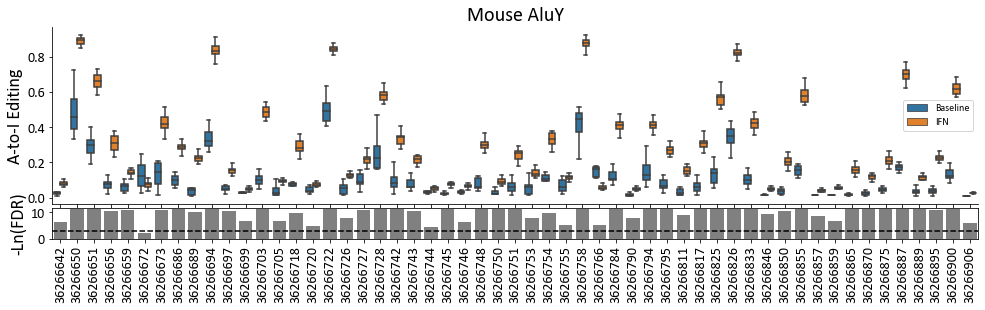

In [ ]:
f, (ax_box1, ax_bar) = plt.subplots(2, sharex=True, figsize=(16.6,23.4/6),
                                    gridspec_kw={"height_ratios": (.85, .15), 'hspace':.035})


start_pos1 = 36266624
end_pos1 = 36266924

df_overed_apol = df_M[df_M.Position.isin(hm.index)]
data1 = df_overed_apol[(df_overed_apol['Position']>=start_pos1) & (df_overed_apol['Position']<=end_pos1)]#.groupby('Position').mean().reset_index()

sns.boxplot(x='Position', y='editing_level', hue='Condition',
            hue_order=['baseline','ifn'], data=data1, fliersize=False, ax=ax_box1)

ax_box1.set_xlabel(None)#\nPosition\n",fontsize=20)
ax_box1.set_ylabel("A-to-I Editing", fontsize=labels_fontsize)
# ax_box1.tick_params(axis='x', rotation=90, labelsize=16)
ax_box1.tick_params(axis='y', labelsize=labels_ticks_fontsize)
ax_box1.set_title('Mouse AluY', fontsize=title_fontsize)
ax_box1.set_axisbelow(True)
ax_box1.spines['right'].set_visible(False)
ax_box1.spines['top'].set_visible(False)

h, l = ax_box1.get_legend_handles_labels()
l = ['Baseline', 'IFN']
ax_box1.legend(h, l)#, fontsize=labels_ticks_fontsize)

data2 = df_stat[(df_stat['Position']>=start_pos1) & (df_stat['Position']<=end_pos1)]

sns.barplot(x='Position', y='log_padj',
            data=data2,color='gray',
            ax=ax_bar)

ax_bar.set_xlabel(None)
ax_bar.axhline(-np.log(0.05), color='black', ls='--')
ax_bar.set_ylabel("-Ln(FDR)", fontsize=labels_fontsize)
ax_bar.tick_params(axis='x', rotation=90, labelsize=labels_ticks_fontsize)
ax_bar.tick_params(axis='y', labelsize=labels_ticks_fontsize)

### Human vs Mouse (Baseline)

#### Undersamplig Human To Baseline quantification

In [ ]:
import matplotlib

In [ ]:
matplotlib.font_manager.fontManager.addfont('/home/guilherme/Documentos/Projetos/calibri font/Calibri Regular/Calibri Regular.ttf')
font_family = 'Calibri'

matplotlib.rcParams['font.family'] = 'Calibri'

In [ ]:
from imblearn.under_sampling import ClusterCentroids

Concatenate df_H and df_M

In [ ]:
df_H.loc[:,'Condition'] = ('Human')

df_H.loc[:,'Specie'] = 'Human'
df_M.loc[:,'Specie'] = 'Mouse'

df_H_M = pd.concat( [df_H[['Position', 'editing_level', 'Condition', 'Specie']],
                     df_M[['Position', 'editing_level', 'Condition', 'Specie']]
                    ]
                  )

Minimum values of 4 samples in each group per position

In [ ]:
aux = df_H_M[df_H_M.Condition!='ifn'].pivot_table(index='Position',
                                            columns='Condition',
                                            values='editing_level',
                                            aggfunc='count').dropna()
aux = aux[(aux.Human>=4) & (aux.baseline>=4)]

Undersampling 

In [ ]:
df_H_M_resampled_list = []

positions = aux.index.values
um5 = 0
for pos in positions:
    X = df_H_M[(df_H_M.Position==pos) & (df_H_M.Condition!='ifn')].editing_level.values.reshape(-1, 1)
    y = df_H_M[(df_H_M.Position==pos) & (df_H_M.Condition!='ifn')].Condition.values

    cc = ClusterCentroids(random_state=0)
    X_resampled, y_resampled = cc.fit_resample(X, y)

    df_H_M_resampled_list.append( pd.DataFrame(X_resampled,columns=['editing_level']) )
    df_H_M_resampled_list[-1]['Condition'] = y_resampled
    df_H_M_resampled_list[-1]['Position'] = pos
    df_H_M_resampled_list[-1]['N'] = 'Undersampled'

df_H_M_resampled= pd.concat(df_H_M_resampled_list)

Calculate Mann-Whitney and correct by Benjamin-Hochberg

In [ ]:
stat_aux = []

for pos in df_H_M_resampled.Position.unique():
    df_pg = pg.pairwise_ttests(dv='editing_level', between='Condition',
                               padjust='fdr_bh',
                               parametric=False,
                               data=df_H_M_resampled[df_H_M_resampled['Position']==pos])
    df_pg['Position'] = pos
    stat_aux.append(df_pg)

df_H_M_stat = pd.concat(stat_aux)

p_values = df_H_M_stat['p-unc'].values
p_adj = sm.stats.multitest.multipletests(p_values.tolist(), method='fdr_bh')
df_H_M_stat['p-adj'] = p_adj[1]
df_H_M_stat['log_padj'] = -np.log(df_H_M_stat['p-adj'])

### FIGURE 5F
#### Human vs Mouse AluSC

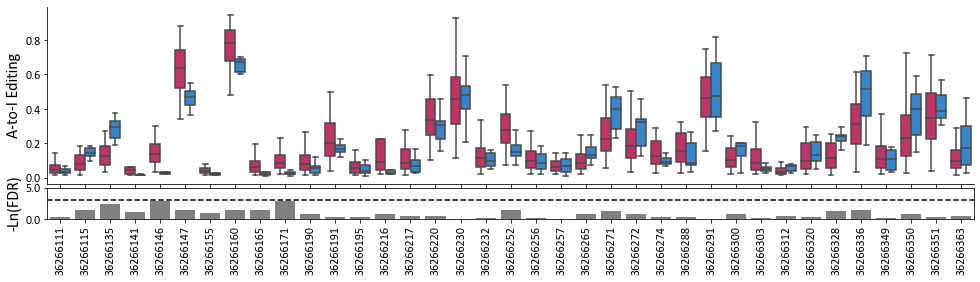

In [ ]:
f, (ax_box1, ax_bar) = plt.subplots(2, sharex=True, figsize=(16.6,23.4/6),
                                    gridspec_kw={"height_ratios": (.85, .15), 'hspace':.035})


start_pos = 36266096
end_pos = 36266380

data = df_H_M_resampled[(df_H_M_resampled['Position']>=start_pos) & (df_H_M_resampled['Position']<=end_pos)]

sns.boxplot(x='Position', y='editing_level', hue='Condition', palette=[human_color, mouse_baseline_color],
            hue_order=['Human','baseline'], data=data, fliersize=False, ax=ax_box1)

ax_box1.set_xlabel(None)
ax_box1.set_ylabel("A-to-I Editing", fontsize=labels_fontsize)
ax_box1.tick_params(axis='y', labelsize=labels_ticks_fontsize)
# ax_box1.set_title('Human vs Mouse AluSc', fontsize=title_fontsize)
ax_box1.set_axisbelow(True)
ax_box1.spines['right'].set_visible(False)
ax_box1.spines['top'].set_visible(False)

ax_box1.legend().remove()
# h, l = ax_box1.get_legend_handles_labels()
# l[1] = 'Baseline'
# ax_box1.legend(h, l, fontsize=labels_ticks_fontsize)

data = df_H_M_stat[(df_H_M_stat['Position']>=start_pos) & (df_H_M_stat['Position']<=end_pos)]

sns.barplot(x='Position', y='log_padj', 
            data=data,color='gray',
            ax=ax_bar)

ax_bar.set_xlabel(None)
ax_bar.axhline(-np.log(0.05), color='black', ls='--')
ax_bar.set_ylabel("-Ln(FDR)", fontsize=labels_fontsize)
ax_bar.tick_params(axis='x', rotation=90, labelsize=labels_ticks_fontsize)
ax_bar.set_ylim((0,5))

ax_bar.tick_params(axis='y', labelsize=labels_ticks_fontsize)
ax_bar.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

f.savefig('REDItools_alusc_mouse_human3.png', format='png', dpi=300, bbox_inches='tight')

#### Human vs Mouse AluY

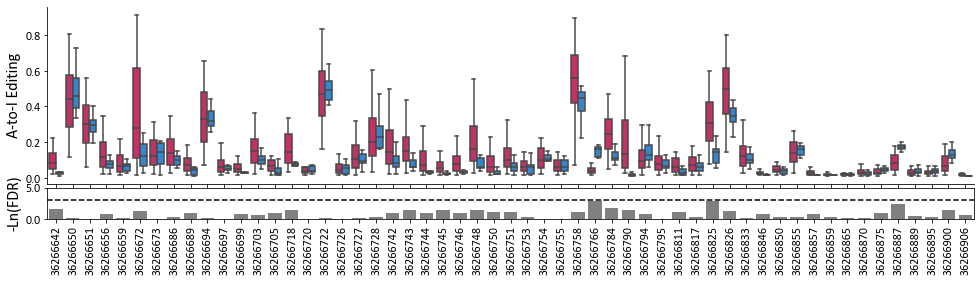

In [ ]:
f, (ax_box1, ax_bar) = plt.subplots(2, sharex=True, figsize=(16.6,23.4/6),
                                    gridspec_kw={"height_ratios": (.85, .15), 'hspace':.035})

start_pos1 = 36266624
end_pos1 = 36266924

data1 = df_H_M_resampled[(df_H_M_resampled['Position']>=start_pos1) & (df_H_M_resampled['Position']<=end_pos1)]

sns.boxplot(x='Position', y='editing_level', hue='Condition', palette=[human_color, mouse_baseline_color],
            hue_order=['Human','baseline'], data=data1, fliersize=False, ax=ax_box1)

ax_box1.set_xlabel(None)
ax_box1.set_ylabel("A-to-I Editing", fontsize=labels_fontsize)
ax_box1.tick_params(axis='y', labelsize=labels_ticks_fontsize)
# ax_box1.set_title('Human vs Mouse AluY', fontsize=title_fontsize)

ax_box1.set_axisbelow(True)
ax_box1.spines['right'].set_visible(False)
ax_box1.spines['top'].set_visible(False)

ax_box1.legend().remove()

# h, l = ax_box1.get_legend_handles_labels()
# l[1] = 'Baseline'
# ax_box1.legend(h, l, fontsize=labels_ticks_fontsize)

data2 = df_H_M_stat[(df_H_M_stat['Position']>=start_pos1) & (df_H_M_stat['Position']<=end_pos1)]

sns.barplot(x='Position', y='log_padj', #order=data2,#.sort_values('p-unc')['Position'],
            data=data2,color='gray',#.sort_values('p-unc'),
            ax=ax_bar)

# ax_bar.set_title('P-values between IFN and Baseline by Position\nNot correct by Benjamini/Hochberg yet', fontsize=18)
ax_bar.set_xlabel(None)
ax_bar.axhline(-np.log(0.05), color='black', ls='--')
ax_bar.set_ylabel("-Ln(FDR)", fontsize=labels_fontsize)
ax_bar.set_ylim((0.0,5.))
ax_bar.tick_params(axis='x', rotation=90, labelsize=labels_ticks_fontsize)

ax_bar.tick_params(axis='y', labelsize=labels_ticks_fontsize)
ax_bar.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

f.savefig('REDItools_aluy_mouse_human3.png', format='png', dpi=300, bbox_inches='tight')

### FIGURE 5D

In [ ]:
from sklearn.preprocessing import MinMaxScaler

Text(0.2, 1.2, 'r  = 0.79\nr² = 0.63')

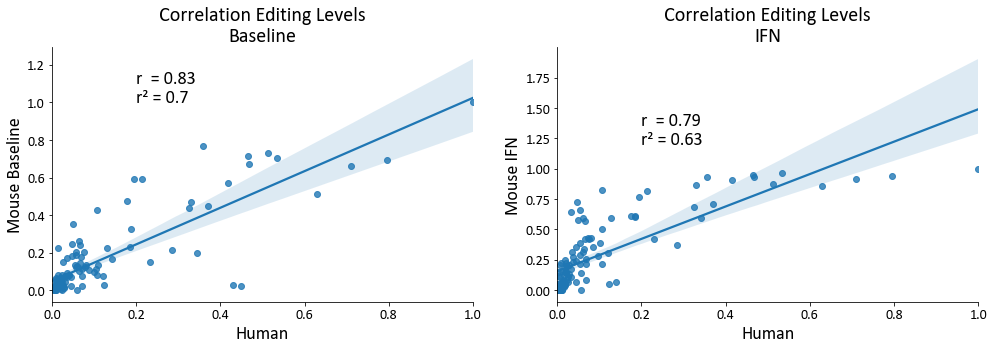

In [ ]:
fig = plt.figure(figsize=(16.6,23.4/5))

H_M_pivot = df_H_M[df_H_M.Condition!='ifn'].sort_values(by='Position').pivot_table(index='Position',
                                                                             columns='Specie',
                                                                             values='editing_level',
                                                                             aggfunc='median').dropna()

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit_transform(H_M_pivot[['Human','Mouse']])
data = scaler.transform(H_M_pivot[['Human','Mouse']])

data=pd.DataFrame(data, columns=['Human','Mouse'])

ax2 = fig.add_subplot(1,2,1)

a = pg.corr(x=data.Human.values,y=data.Mouse.values, method='pearson')

sns.regplot(x='Human', y='Mouse', data=data, ax=ax2)

ax2.set_title('Correlation Editing Levels\nBaseline', fontsize=title_fontsize)
ax2.set_ylabel("Mouse Baseline", fontsize=labels_fontsize)
ax2.set_xlabel("Human", fontsize=labels_fontsize)
ax2.tick_params(axis='both', labelsize=labels_ticks_fontsize)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.text(x=.2, y=1., s='r  = '+str(round(a.r.pearson, 2))+'\nr² = '+str(round(a.r.pearson**2, 2)), fontsize= labels_fontsize)

######################
######################

H_M_pivot = df_H_M[df_H_M.Condition!='baseline'].sort_values(by='Position').pivot_table(index='Position',
                                                                             columns='Specie',
                                                                             values='editing_level',
                                                                             aggfunc='median').dropna()
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit_transform(H_M_pivot[['Human','Mouse']])
data = scaler.transform(H_M_pivot[['Human','Mouse']])

data=pd.DataFrame(data, columns=['Human','Mouse'])

ax3 = fig.add_subplot(1,2,2)

a = pg.corr(x=data.Human.values,y=data.Mouse.values, method='pearson')

sns.regplot(x='Human', y='Mouse', data=data, ax=ax3)

ax3.set_title('Correlation Editing Levels\nIFN', fontsize=title_fontsize)
ax3.set_ylabel("Mouse IFN", fontsize=labels_fontsize)
ax3.set_xlabel("Human", fontsize=labels_fontsize)
ax3.tick_params(axis='both', labelsize=labels_ticks_fontsize)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

ax3.text(x=.2, y=1.2, s='r  = '+str(round(a.r.pearson, 2))+'\nr² = '+str(round(a.r.pearson**2, 2)), fontsize= labels_fontsize)

### FIGURE 5C

In [ ]:
import venn

<AxesSubplot:>

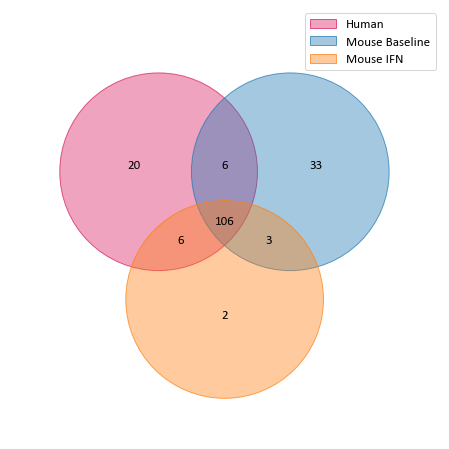

In [ ]:
pos_pool = {'Human':set(df_H.Position.dropna().values.tolist()),
            'Mouse Baseline':set(df_M[df_M.Condition=='baseline'].Position.dropna().values.tolist()),
            'Mouse IFN':set(df_M[df_M.Condition=='ifn'].Position.dropna().values.tolist())}

venn.venn(pos_pool, cmap=[(216/255, 27/255, 96/255,.7),
                          (0.12156862745098039, 0.4666666666666667, 0.7058823529411765,.75),
                          (1.0, 0.4980392156862745, 0.054901960784313725,.75)])

In [ ]:
# Does make no sense to do it, because we wnt to no other positions beyond comparasion
pos = df_H_M_resampled.Position.tolist()

<AxesSubplot:>

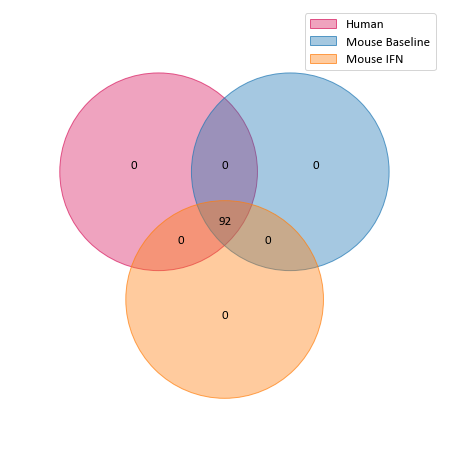

In [ ]:
pos_pool = {'Human':set(df_H[df_H.Position.isin(pos)].Position.dropna().values.tolist()),
            'Mouse Baseline':set(df_M[(df_M.Position.isin(pos)) & (df_M.Condition=='baseline')].Position.dropna().values.tolist()),
            'Mouse IFN':set(df_M[(df_M.Position.isin(pos)) & (df_M.Condition=='ifn')].Position.dropna().values.tolist())}

venn.venn(pos_pool, cmap=[(216/255, 27/255, 96/255,.7),
                          (0.12156862745098039, 0.4666666666666667, 0.7058823529411765,.75),
                          (1.0, 0.4980392156862745, 0.054901960784313725,.75)])

# Incoherent Type-I FFL 

We simulated to states of ADAR concentrations:

- **Low** Adarconcentration Beta = 0.025
- **High** Aadr concentraition Beta = 1.6

To define a Beta, we considered the result of figure 1B. Where the ratio **$\frac{siADAR}{siScramble} \approx 2$**

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import biocircuits
import colorcet
colors = colorcet.b_glasbey_category10 

The follow functions were developed by [Michael Elowitz and Justin Bois](http://be150.caltech.edu/2020/content/lessons/05_ffls.html)

In [ ]:
def rhs(yz, t, x, beta, gamma, kappa, nxy, nxz, nyz):
    y, z = yz
    
    dy_dt = beta * biocircuits.reg.act_hill(kappa*x, nxy) - y
    dz_dt = gamma * (biocircuits.reg.ar_and(x, y, nxz, nyz) - z)

    return np.array([dy_dt, dz_dt])

def xyz(t,t_step_down, x_0, beta, gamma, kappa, nxy, nxz, nyz, step=True):
    
    if step:
        # Integrate up to step down
        p = (x_0, beta, gamma, kappa, nxy, nxz, nyz)
        t_during_step = np.concatenate((t[t < t_step_down], (t_step_down,)))
        yz_during_step = odeint( rhs, np.zeros(2), t_during_step, args=p )

        # Integrate after step
        p = (0, beta, gamma, kappa, nxy, nxz, nyz)
        t_after_step = np.concatenate(((t_step_down,), t[t > t_step_down]))
        yz_after_step = odeint( rhs, yz_during_step[-1, :], t_after_step, args=p ) 
        
        # Concatenate solutions
        if t_step_down in t:
            yz1 = np.vstack((yz_during_step[:-1, :], yz_after_step))
        else:
            yz1 = np.vstack((yz_during_step[:-1, :], yz_after_step[1:, :]))
        
    else:
        p = (x_0, beta, gamma, kappa, nxy, nxz, nyz)
        yz1 = odeint( rhs, np.zeros(2), t, args=p )
        
    y, z = yz1.transpose()
        
    if t[-1] > t_step_down:
        t_x = np.array(
            [-t_step_down / 10, 0, 0, t_step_down, t_step_down, t[-1]]
        )
        x = np.array([0, 0, x_0, x_0, 0, 0])
    else:
        t_x = np.array([-t[-1] / 10, 0, 0, t[-1]])
        x = np.array([0, 0, x_0, x_0])
        
    t = np.concatenate(((t_x[0],), t))
    y = np.concatenate(((0,), y))
    z = np.concatenate(((0,), z))    
        
    return x,y,z,t_x,t

### Exhaustive algorithm to define Beta when ratio is approximately 2

In [ ]:
t=np.linspace(0, 20, 200)
t_step_down=10
x_0=2
beta = 1
gamma = 1
kappa = 1
nxy=1
nxz=1
nyz=1

betas_test = []
for i in [i for i in np.linspace(0, 3, 50)]:
    x1,y1,z1,t_x,t2 = xyz(t,t_step_down, x_0, 0.025, gamma, kappa, nxy, nxz, nyz)
    x2,y2,z2,t_x,t2 = xyz(t,t_step_down, x_0, i, gamma, kappa, nxy, nxz, nyz)
    
    if z1[100]/z2[100] >=2:
        betas_test.append([i,z1[100],z2[100]])
print('minor Beta =', betas_test[0][0], '~', round(betas_test[0][0],1))

minor Beta = 1.5918367346938775 ~ 1.6


### Figure 2B

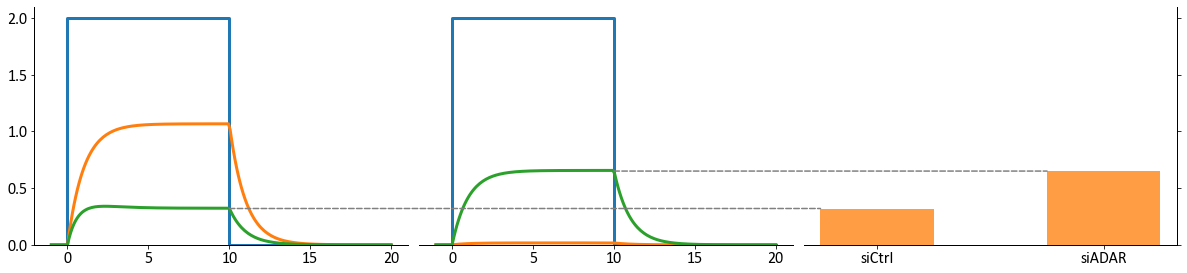

In [ ]:
fig, (axb1, axb0, axbx) = plt.subplots(1, 3, sharey=True, figsize=(16.6,23.4/6))#figsize=(15,5))23.4/6
# fig.suptitle('I1-FFL modeling for IFN, ADAR and APOL1\n', fontsize=18)

linewidth = 3
x,y,z,t_x,t2 = xyz(t,t_step_down, x_0, 0.025, gamma, kappa, nxy, nxz, nyz)

axb0.plot(t_x,x, label='IFN',color=colors[0], linewidth=linewidth)

axb0.plot(t2, y,'-', label='ADAR', color=colors[1], linewidth=linewidth)
axb0.plot(t2, z,'-',label='APOL1',color=colors[2], linewidth=linewidth)
axb0.axes.get_yaxis().set_visible(False)
axb0.spines['left'].set_visible(False)
axb0.spines['right'].set_visible(False)
axb0.spines['top'].set_visible(False)
axb0.spines['bottom'].set_linewidth(1)
# axb0.set_title('β=0.025\n', fontdict={'size':title_fontsize})
axb0.tick_params(axis='x', labelsize=labels_ticks_fontsize+4)
# axb0.tick_params(axis='y', labelsize=labels_ticks_fontsize)

x,y,z,t_x,t2 = xyz(t,t_step_down, x_0, 1.6, gamma, kappa, nxy, nxz, nyz)

axb1.plot(t_x,x,'-', label='IFN', color=colors[0], linewidth=linewidth)
axb1.plot(t2, y, label='ADAR', color=colors[1], linewidth=linewidth)
axb1.plot(t2, z, label='APOL1',color=colors[2], linewidth=linewidth)
axb1.spines['right'].set_visible(False)
axb1.spines['top'].set_visible(False)
axb1.spines['left'].set_linewidth(1)
axb1.spines['bottom'].set_linewidth(1)
# axb1.set_ylabel('Dimensionless concentration', fontdict={'size':labels_fontsize})
# axb1.set_xlabel('Dimensionless time', fontdict={'size':labels_fontsize})
# axb1.set_title('β=1.6\n', fontdict={'size':title_fontsize})
axb1.tick_params(axis='x', labelsize=labels_ticks_fontsize+4)
axb1.tick_params(axis='y', labelsize=labels_ticks_fontsize+4)

# axb1.legend(loc='upper right',  prop={'size': 14})

bar = axbx.bar(['siCtrl','siADAR'],[0.32,0.65], color='#FF9D44',  width=0.5)
axbx.spines['left'].set_visible(False)
axbx.spines['top'].set_visible(False)
axbx.spines['bottom'].set_linewidth(1)
axbx.spines['right'].set_linewidth(1)
# axbx.set_title('Simulated experimental ratio\n', fontdict={'size':title_fontsize})
axbx.yaxis.tick_right()
# axbx.text(1.38, 0.2, 'Relative APOL1 expression', rotation=270, fontsize=14)
axbx.tick_params(axis='x', labelsize=labels_ticks_fontsize+4)
# axbx.tick_params(axis='y', labelsize=labels_ticks_fontsize)

con = ConnectionPatch(xyA=(10,0.65), xyB=(.75,0.65), coordsA="data", coordsB="data",
                      axesA=axb0, axesB=axbx, color="gray", ls='--', lw=1.5)
axbx.add_artist(con)

con = ConnectionPatch(xyA=(10,0.32), xyB=(-.25,0.32), coordsA="data", coordsB="data",
                      axesA=axb1, axesB=axbx, color="gray", ls='--', lw=1.5)
axbx.add_artist(con)

fig.tight_layout()

fig.savefig('I1FFL_splited_simulated_experimental2.png', dpi=300, format='png')

### Figure 2C 2D

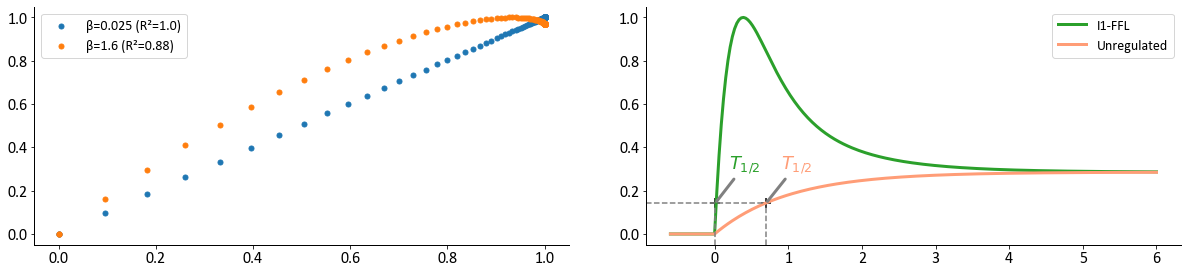

In [ ]:
fig = plt.figure(figsize=(16.6,23.4/6))#5))#

ax1 = fig.add_subplot(121)

t=np.linspace(0, 20, 200)
t_step_down=10
x_0=2
beta = 1
gamma = 1
kappa = 1
nxy=1
nxz=1
nyz=1

i=0
for b in [0.025,1.6]:


    x,y,z,t_x,t2 = xyz(t,t_step_down, 1, b, gamma, kappa, nxy, nxz, nyz, False)

    y = ( y - y.min() ) / ( y.max() - y.min() )
    z = ( z - z.min() ) / ( z.max() - z.min() )
    
    res_reg = linregress(y,z)
    ax1.scatter(y,z,s=25,color=colors[i], label='β='+str(b)+' (R\u00b2='+str(round(res_reg.rvalue**2, 2))+')' )

    i+=1

# ax1.set_ylabel('APOL1 concentration', fontdict={'size':14})
# ax1.set_xlabel('ADAR concentration', fontdict={'size':14})
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_linewidth(1)
ax1.spines['bottom'].set_linewidth(1)
ax1.tick_params(axis='both', labelsize=labels_ticks_fontsize+4)
# ax1.set_title('Scatter plot of ADAR vs APOL1\ndimensionless concentration\n', fontsize=16)

ax1.legend(prop={'size':14})

##############
##############

axb0 = fig.add_subplot(122)
x_0 = 10

t=np.linspace(0, 6, 200)

zu_ds = (1 - np.exp(-t))*0.28558802
zu = np.insert(zu_ds, 0, 0)

beta = 2
gamma = 5
kappa = 1
nxy = 2
nxz = 3
nyz = 2

x,y,z,t_x,t2 = xyz(t,t_step_down, x_0, beta, gamma, kappa, nxy, nxz, nyz, False)
z = ( z - z.min() ) / ( z.max() - z.min() ) 

axb0.scatter([.7, .01], [.143,.143], alpha=1, color='black', s=100, marker='+')
axb0.annotate('$T_{1/2}$', (.01,.143), (.2,.3), fontsize=18, color=colors[2], weight='bold',
              arrowprops={'facecolor':'black',
                          'arrowstyle':'-',
                          'linewidth':3,
                          'edgecolor':'grey'},
             )

axb0.annotate('$T_{1/2}$', (.7,.143), (.9,.3), fontsize=18, color='#FF9D77',  weight='bold',
              arrowprops={'facecolor':'black',
                          'arrowstyle':'-',
                          'linewidth':3,
                          'edgecolor':'grey'},
             )


axb0.plot(t2, z, label='I1-FFL',color=colors[2], linewidth=linewidth)
axb0.plot(t2, zu , label='Unregulated',color='#FF9D77', linewidth=linewidth)

axb0.spines['right'].set_visible(False)
axb0.spines['top'].set_visible(False)
axb0.spines['left'].set_linewidth(1)
axb0.spines['bottom'].set_linewidth(1)
axb0.tick_params(axis='both', labelsize=labels_ticks_fontsize+4)
# axb0.set_ylabel('Dimensionless concentration', fontdict={'size':14})
# axb0.set_xlabel('Dimensionless time', fontdict={'size':14})


axb0.axhline(y = .143, xmax=.22, ls='--', lw=1.5, color='grey')
axb0.axvline(x = .7, ymax=.16, ls='--', lw=1.5, color='grey')
axb0.axvline(x = .01, ymax=.16, ls='--', lw=1.5, color='grey')

# axb0.set_title('I1-FFL gives accelerated response\n\n', fontdict={'size':16})


axb0.legend(prop={'size':14})

fig.tight_layout(w_pad=5)
fig.savefig('I1FFL_ADARvsAPOL1_I1FFLAceleratedResponse2.png', dpi=300, format='png')